In [149]:
import os
import glob
import re
from cycler import cycler
import numpy as np
from astropy.table import Table
import astropy
import astropy.stats
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import ciao_contrib.runtool as rt

In [3]:
datapath = '/melkor/d1/guenther/downdata/Chandra/ONC/17735/'
temppath = '/melkor/d1/guenther/processing/ONC/'

In [4]:
evt2 = glob.glob(os.path.join(datapath, 'repro', '*evt2.fits'))[0]
asol = glob.glob(os.path.join(datapath, 'repro', '*asol*'))[0]
asol

'/melkor/d1/guenther/downdata/Chandra/ONC/17735/repro/pcadf596601034N001_asol1.fits'

In [5]:
with open('celldetect_handedited.reg', 'r') as regfile:
    regs = [r.replace('\n', '') for r in regfile]

In [176]:
regs[5]

"ellipse(5:35:45.0652,-5:26:53.758,0.08509',0.05143',32.190121)"

In [160]:
rt.dmcopy(infile="{}[EVENTS][energy=400:8000][bin x=2500:5500:5, y=2600:5500:5]".format(evt2),
          outfile=temppath+'image04_80.fits', option='image')

In [24]:
for i, reg in enumerate(regs):
    rt.dmcopy(infile="{}[sky={},energy=400:10000]".format(evt2, reg), outfile=temppath+'src{}.fits'.format(i))

In [7]:
n_good = []
for i, reg in enumerate(regs):
    rt.dmstat(infile=temppath+'src{}.fits[col time]'.format(i), verbose=0)
    n_good.append(int(rt.dmstat.out_good))
    

In [8]:
src = Table(data={'n': np.arange(len(regs)), 'reg': regs, 'n_good': n_good})

In [9]:
src.sort('n_good')

In [91]:
Do not run!

for row in src:
    rt.dither_region(infile=asol, 
                     region="{}".format(row['reg']), 
                     outfile=temppath+'fracarea{}.fits'.format(row['n']),
                     wcsfile=temppath+'src{}.fits'.format(row['n']),
                     clobber=True)
    evt = Table.read(temppath + 'src{}.fits'.format(row['n']), hdu=1)
    # For sources dithering over different CCDs, do lightcurve where they spend most time
    # GLVary uses dither file, so is selecting on CCD id helpful or harmful?
    ccd_ids = np.bincount(evt['ccd_id'])
    rt.glvary(infile=temppath+'src{}.fits[ccd_id={}]'.format(row['n'], np.argmax(ccd_ids)),
             effile=temppath+'fracarea{}.fits[cols time,dtf=fracarea]'.format(row['n']),
             outfile=temppath+'gl_prop{}.fits'.format(row['n']),
             lcfile=temppath+'lc_prop{}.fits'.format(row['n']),
             clobber=True)

In [48]:
src['GLvary'] = [fits.getval(temppath + 'gl_prop{}.fits'.format(n), keyword='VARINDEX', ext=1) for n in src['n']]

In [50]:
src['maxlc'] = [np.max(Table.read(temppath + 'lc_prop{}.fits'.format(n))['COUNT_RATE']) for n in src['n']]

In [11]:
src['ra'] = [s.split('(')[1].split(',')[0] for s in src['reg']]
src['dec'] = [s.split('(')[1].split(',')[1] for s in src['reg']]
# SkyCoords are not mutable and thus table with Coords mixins are not sortable so dont' add this.
#src['pos'] = SkyCoord(src['ra'], src['dec'], unit=(u.hourangle, u.deg))

In [13]:
src.sort(['GLvary', 'n_good'])

In [14]:
src

n,n_good,reg,GLvary,ra,dec
int64,int64,str63,int64,str12,str12
27,13,"ellipse(5:35:33.3361,-5:30:15.892,0.08407',0.07086',17.64213)",0,5:35:33.3361,-5:30:15.892
600,16,"ellipse(5:34:56.8008,-5:20:13.896,0.09994',0.08404',108.29555)",0,5:34:56.8008,-5:20:13.896
158,20,"ellipse(5:35:22.6351,-5:21:36.990,0.01902',0.02698',73.502594)",0,5:35:22.6351,-5:21:36.990
115,20,"ellipse(5:35:24.9410,-5:25:10.748,0.07541',0.03670',50.843224)",0,5:35:24.9410,-5:25:10.748
251,21,"ellipse(5:35:18.6842,-5:23:14.279,0.07367',0.03869',70.773544)",0,5:35:18.6842,-5:23:14.279
137,23,"ellipse(5:35:23.8498,-5:18:21.356,0.08061',0.07161',125.86255)",0,5:35:23.8498,-5:18:21.356
578,27,"ellipse(5:35:01.2513,-5:21:44.215,0.07524',0.05921',151.54079)",0,5:35:01.2513,-5:21:44.215
537,27,"ellipse(5:35:06.4373,-5:21:18.546,0.07011',0.05253',165.51807)",0,5:35:06.4373,-5:21:18.546
123,27,"ellipse(5:35:24.6159,-5:21:04.631,0.06989',0.06377',70.272034)",0,5:35:24.6159,-5:21:04.631


In [53]:
src16 = src[(src['maxlc'] > .1) & (src['GLvary'] >=8)]
src16

n,n_good,reg,GLvary,ra,dec,maxlc
int64,int64,str63,int64,str12,str12,float64
266,15535,"ellipse(5:35:18.3623,-5:22:37.217,0.03227',0.02998',122.9265)",8,5:35:18.3623,-5:22:37.217,0.18177096339734716
355,7976,"ellipse(5:35:15.6261,-5:22:56.178,0.03222',0.02839',110.88132)",9,5:35:15.6261,-5:22:56.178,0.11275764363942749
508,9309,"ellipse(5:35:09.7577,-5:23:26.662,0.03082',0.02793',93.921082)",9,5:35:09.7577,-5:23:26.662,0.12025364435368699
326,24606,"ellipse(5:35:16.4562,-5:23:22.818,0.06272',0.05780',69.086357)",9,5:35:16.4562,-5:23:22.818,0.2876143279355597
248,1491,"ellipse(5:35:18.8450,-5:21:40.939,0.03328',0.02894',138.68167)",10,5:35:18.8450,-5:21:40.939,0.11296278583072364
468,1689,"ellipse(5:35:11.8904,-5:21:02.885,0.04017',0.02991',124.00887)",10,5:35:11.8904,-5:21:02.885,0.11044563758005999
110,1832,"ellipse(5:35:25.4155,-5:21:51.303,0.04026',0.02964',176.13458)",10,5:35:25.4155,-5:21:51.303,0.1758465240998561
217,2693,"ellipse(5:35:20.1381,-5:13:15.342,0.07836',0.06020',150.12328)",10,5:35:20.1381,-5:13:15.342,0.10203684099783841
238,3312,"ellipse(5:35:19.2047,-5:22:50.485,0.03175',0.03138',8.349926)",10,5:35:19.2047,-5:22:50.485,0.10710867755469518


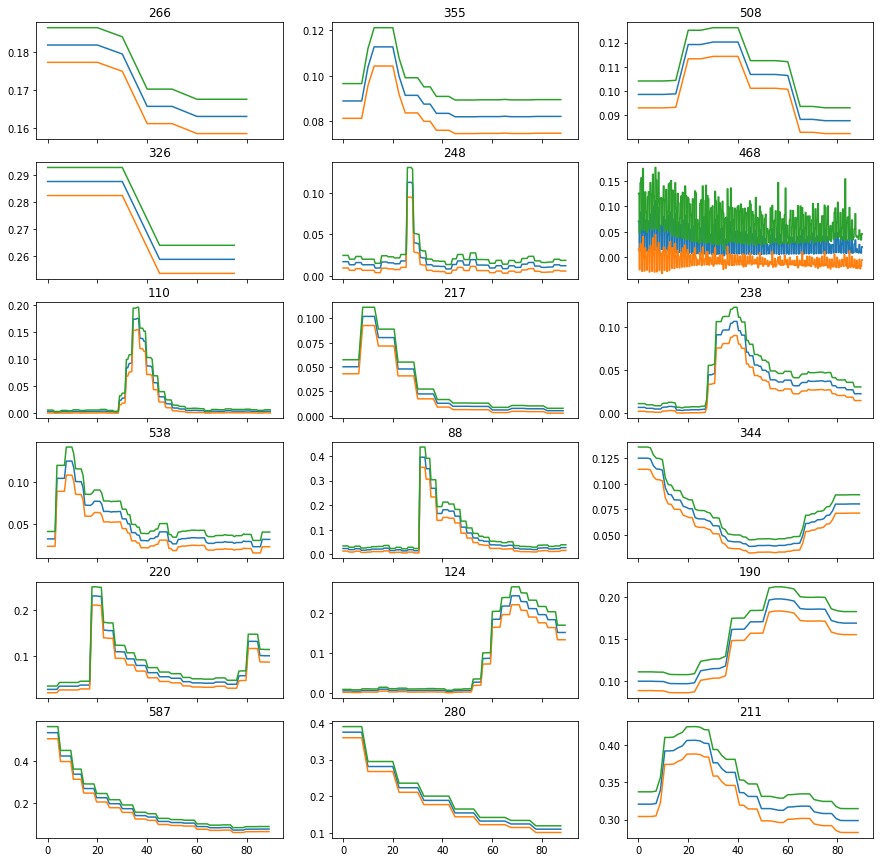

In [84]:
fig, axes = plt.subplots(6, 3, sharex='all', figsize=(15, 15))
for i in range(axes.size):
    lcp = Table.read(temppath + 'lc_prop{}.fits'.format(src16['n'][i]))
    ax = axes.flatten()[i]
    ax.plot((lcp['Time'] - lcp['Time'][0])/1e3, lcp['COUNT_RATE'])
    #ax.plot((lcp['Time'] - lcp['Time'][0])/1e3, lcp['Minus_3Sig'])
    #ax.plot((lcp['Time'] - lcp['Time'][0])/1e3, lcp['Plus_3Sig'])
    
    ax.set_title(src16['n'][i])

In [166]:
src16

n,n_good,reg,GLvary,ra,dec,maxlc
int64,int64,str63,int64,str12,str12,float64
266,15535,"ellipse(5:35:18.3623,-5:22:37.217,0.03227',0.02998',122.9265)",8,5:35:18.3623,-5:22:37.217,0.18177096339734716
355,7976,"ellipse(5:35:15.6261,-5:22:56.178,0.03222',0.02839',110.88132)",9,5:35:15.6261,-5:22:56.178,0.11275764363942749
508,9309,"ellipse(5:35:09.7577,-5:23:26.662,0.03082',0.02793',93.921082)",9,5:35:09.7577,-5:23:26.662,0.12025364435368699
326,24606,"ellipse(5:35:16.4562,-5:23:22.818,0.06272',0.05780',69.086357)",9,5:35:16.4562,-5:23:22.818,0.2876143279355597
248,1491,"ellipse(5:35:18.8450,-5:21:40.939,0.03328',0.02894',138.68167)",10,5:35:18.8450,-5:21:40.939,0.11296278583072364
468,1689,"ellipse(5:35:11.8904,-5:21:02.885,0.04017',0.02991',124.00887)",10,5:35:11.8904,-5:21:02.885,0.11044563758005999
110,1832,"ellipse(5:35:25.4155,-5:21:51.303,0.04026',0.02964',176.13458)",10,5:35:25.4155,-5:21:51.303,0.1758465240998561
217,2693,"ellipse(5:35:20.1381,-5:13:15.342,0.07836',0.06020',150.12328)",10,5:35:20.1381,-5:13:15.342,0.10203684099783841
238,3312,"ellipse(5:35:19.2047,-5:22:50.485,0.03175',0.03138',8.349926)",10,5:35:19.2047,-5:22:50.485,0.10710867755469518


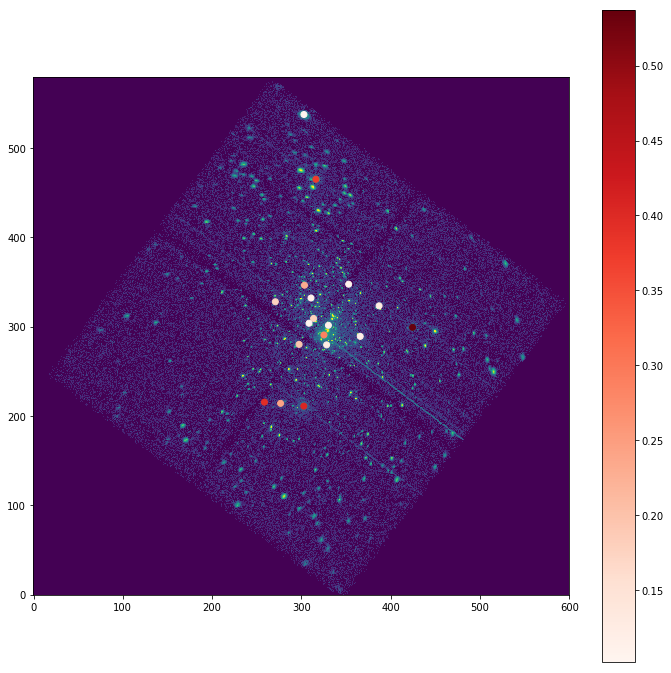

In [56]:
from astropy.visualization import simple_norm

hdu = fits.open(temppath+'image04_80.fits')[0]
wcs = WCS(hdu.header)

fig, ax = plt.subplots(1,1, figsize=(12,12))
norm = simple_norm(hdu.data, 'log', max_cut=1000)
ax.imshow(hdu.data, origin='lower', norm=norm)

pos = SkyCoord(src16['ra'], src16['dec'], unit=(u.hourangle, u.deg))
x, y = wcs.all_world2pix(pos.ra, pos.dec, 0)
out = ax.scatter(x, y, c=src16['maxlc'], cmap=plt.get_cmap('Reds'))
plt.colorbar(out)

In [46]:
src[src['n'] == 486]

n,n_good,reg,GLvary,ra,dec
int64,int64,str63,int64,str12,str12
486,148,"ellipse(5:35:10.9504,-5:22:46.550,0.06379',0.05071',171.31741)",2,5:35:10.9504,-5:22:46.550


In [82]:
lcp

Time,COUNT_RATE,COUNT_RATE_ERR,Minus_3Sig,Plus_3Sig
s,ct / s,ct / s,ct / s,ct / s
float64,float64,float64,float64,float64
596602620.026734,0.32077089567337036,0.005542346144134461,0.304143857240967,0.33739793410577373
596604386.4100058,0.32077089567337036,0.005542346144134461,0.304143857240967,0.33739793410577373
596606152.7932775,0.32077089567337036,0.005542346144134461,0.304143857240967,0.33739793410577373
596607919.1765493,0.320772843767752,0.005542365899076637,0.3041457460705221,0.3373999414649819
596609685.559821,0.3216609117321309,0.005550546673069534,0.3050092717129223,0.3383125517513395
596611451.9430928,0.3397226305048196,0.005691250576058894,0.32264887877664294,0.35679638223299626
596613218.3263646,0.392518313850131,0.006051744254396416,0.3743630810869417,0.41067354661332023
596614984.7096363,0.39252004686395464,0.006051760370932801,0.37436476575115624,0.41067532797675305


In [83]:
np.diff(lcp['Time'])

1766.3832718133926
1766.3832716941833
1766.3832718133926
1766.3832716941833
1766.3832718133926
1766.3832718133926
1766.3832716941833
1766.3832718133926
1766.3832716941833
1766.3832718133926
1766.3832716941833


In [158]:
def build_lcs(n, energies=[(500,2000), (2000, 4000), (4000, 10000), (500, 10000)], timedel=None):
    rt.dmextract.punlearn()
    evt = Table.read(temppath + 'src{}.fits'.format(n), hdu=1)
    # For sources dithering over different CCDs, do lightcurve where they spend most time
    ccd_ids = np.bincount(evt['ccd_id'])
    if timedel is None:
        timedel = fits.getval(temppath + 'lc_prop{}.fits'.format(n), 'TIMEDEL', ext=1)
    # Build stack on input files in dm stack syntax
    infiles = [temppath + "src{}.fits[ccd_id={}][energy={}:{}][bin time=::{}]".format(n, np.argmax(ccd_ids),
                                                                                      en[0], en[1], timedel)
               for en in energies]
    rt.dmextract(infile=','.join(infiles),
                 outfile=temppath + "src{}_lc.fits".format(n),
                 opt="ltc2", clobber=True)
    
def HR(band1, band2):
    return (band1-band2) / (band1 + band2)

In [134]:
n = 88
build_lcs(n, timedel=1000)
lc = Table.read(temppath + "src{}_lc.fits".format(n), hdu=1)

In [1]:
custom_cycler = (cycler(color=['#d62728', '#ff7f0e', '#1f77b4', 'k']) +
                 cycler(lw=[2, 2, 2, 3]))

NameError: name 'cycler' is not defined

In [2]:
enlimits = re.compile('\[energy=(?P<enlow>[0-9]+):(?P<enhigh>[0-9]+)\]')

fig, ax = plt.subplots()
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.set_prop_cycle(custom_cycler)
axt = ax.twinx()
for row in lc:
    enlow, enhigh = enlimits.search(row['SELECT']).groups()
    ax.plot((row['TIME'] - lc.meta['TSTART'])/1e3, row['COUNT_RATE'],
            label='{:4.1f}-{:4.1f} keV'.format(float(enlow) / 1e3, float(enhigh) / 1e3))
    
axt.plot((row['TIME'] - lc.meta['TSTART'])/1e3, 
        HR(lc['COUNT_RATE'][1] + lc['COUNT_RATE'][2], lc['COUNT_RATE'][0]), alpha=.3, color='k', lw=10)
out = ax.legend()

NameError: name 're' is not defined

In [150]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [162]:
for n in src16['n']:
    build_lcs(n, timedel=1000)

/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao-4.12b1a/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


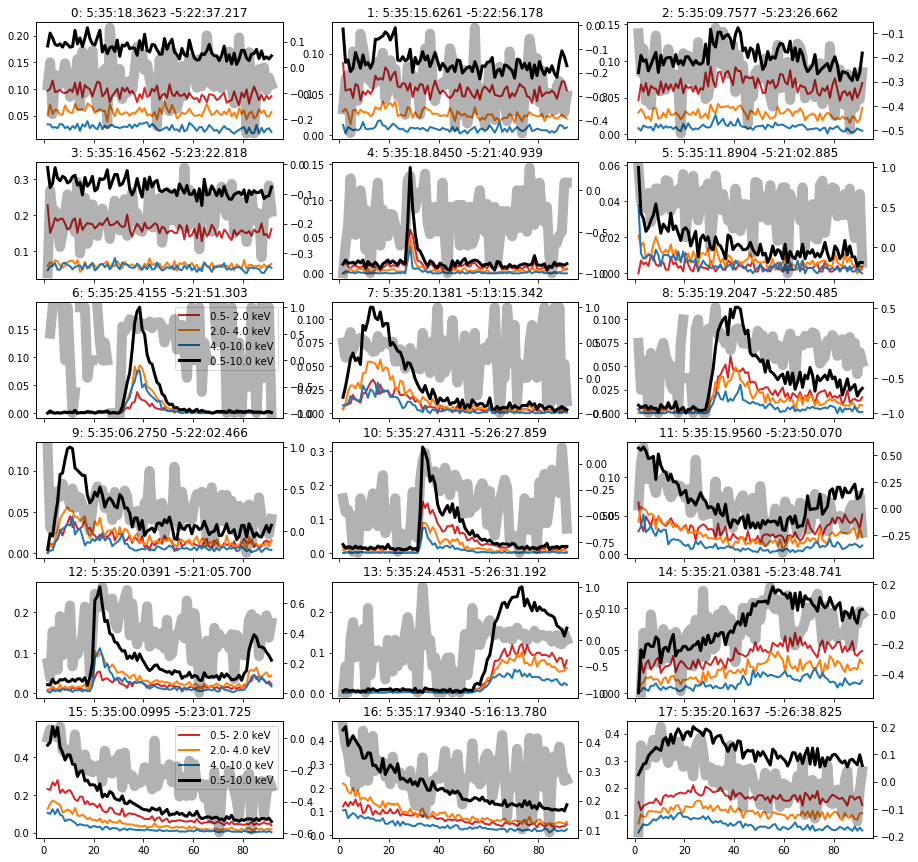

In [172]:
fig, axes = plt.subplots(6, 3, sharex='all', figsize=(15, 15))
for i in range(axes.size):
    source = src16[i]
    n = source['n']
    lc = Table.read(temppath + "src{}_lc.mexfits".format(n), hdu=1)
    ax = axes.flatten()[i]
    ax.set_prop_cycle(custom_cycler)
    axt = ax.twinx()
    for row in lc:
        enlow, enhigh = enlimits.search(row['SELECT']).groups()
        ax.plot((row['TIME'][1:-1] - lc.meta['TSTART'])/1e3, row['COUNT_RATE'][1:-1],
                label='{:4.1f}-{:4.1f} keV'.format(float(enlow) / 1e3, float(enhigh) / 1e3))
    
    axt.plot((row['TIME'][1:-1] - lc.meta['TSTART'])/1e3, 
              HR(lc['COUNT_RATE'][1] + lc['COUNT_RATE'][2], lc['COUNT_RATE'][0])[1:-1], alpha=.3, color='k', lw=10)
    ax.set_title('{}: {} {}'.format(i, source['ra'], source['dec']))
out = axes[2, 0].legend()
out = axes[5, 0].legend()

In [174]:
src16.write(sys.stdout, format='ascii')

n n_good reg GLvary ra dec maxlc
266 15535 ellipse(5:35:18.3623,-5:22:37.217,0.03227',0.02998',122.9265) 8 5:35:18.3623 -5:22:37.217 0.18177096339734716
355 7976 ellipse(5:35:15.6261,-5:22:56.178,0.03222',0.02839',110.88132) 9 5:35:15.6261 -5:22:56.178 0.11275764363942749
508 9309 ellipse(5:35:09.7577,-5:23:26.662,0.03082',0.02793',93.921082) 9 5:35:09.7577 -5:23:26.662 0.12025364435368699
326 24606 ellipse(5:35:16.4562,-5:23:22.818,0.06272',0.05780',69.086357) 9 5:35:16.4562 -5:23:22.818 0.2876143279355597
248 1491 ellipse(5:35:18.8450,-5:21:40.939,0.03328',0.02894',138.68167) 10 5:35:18.8450 -5:21:40.939 0.11296278583072364
468 1689 ellipse(5:35:11.8904,-5:21:02.885,0.04017',0.02991',124.00887) 10 5:35:11.8904 -5:21:02.885 0.11044563758005999
110 1832 ellipse(5:35:25.4155,-5:21:51.303,0.04026',0.02964',176.13458) 10 5:35:25.4155 -5:21:51.303 0.1758465240998561
217 2693 ellipse(5:35:20.1381,-5:13:15.342,0.07836',0.06020',150.12328) 10 5:35:20.1381 -5:13:15.342 0.10203684099783841
238 